[*********************100%***********************]  1 of 1 completed


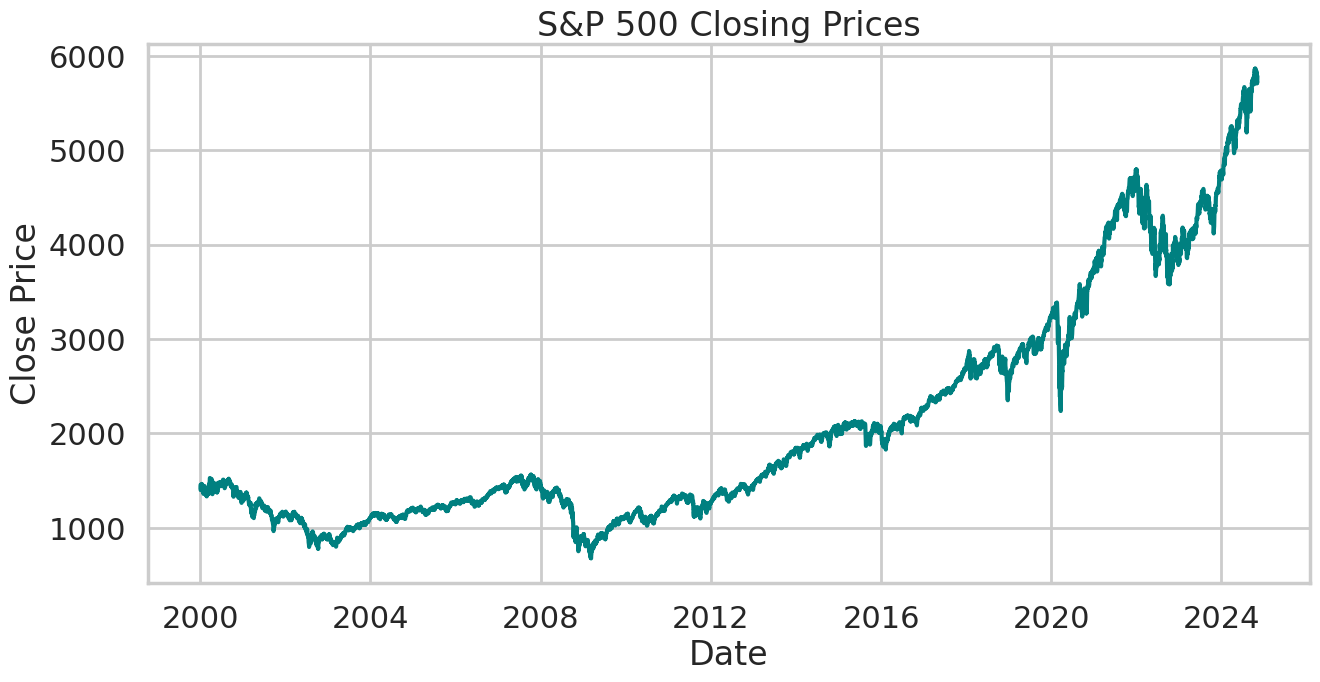


Data range:
2000-01-03 00:00:00+00:00 2024-11-05 00:00:00+00:00


In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import time
import numpy as np
import pandas as pd
import yfinance as yf

from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Set the style for plots
sns.set_style('whitegrid')
sns.set_context('poster')

# Define the start and end dates
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime.now()

# Download S&P 500 data using yfinance
sp_df = yf.download('^GSPC', start=start_date, end=end_date)
sp_close_series = sp_df['Close']

# Plot the closing prices
plt.figure(figsize=(15, 7))
plt.plot(sp_close_series, color='teal')
plt.title('S&P 500 Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

print("\nData range:")
print(sp_df.index.min(), sp_df.index.max())




In [17]:
sp_df.index.min(), sp_df.index.max()

(Timestamp('2000-01-03 00:00:00+0000', tz='UTC'),
 Timestamp('2024-11-05 00:00:00+0000', tz='UTC'))

In [ ]:

WINDOW = 60  # Typically a larger window is used for LSTM
PRED_LENGTH = int(WINDOW / 2)


def get_reg_train_test(timeseries, sequence_length=51,
                       train_size=0.9, roll_mean_window=5,
                       normalize=True, scale=False):
    # Ensure the timeseries is numeric
    timeseries = pd.to_numeric(timeseries, errors='coerce').dropna()
    
    # Debugging: Check the first few values after conversion
    print("\nInside get_reg_train_test - after conversion to numeric:")
    print(timeseries.head())
    
    # Smoothen out series if roll_mean_window is set
    if roll_mean_window:
        timeseries = timeseries.rolling(roll_mean_window).mean().dropna()
        print("\nAfter rolling mean:")
        print(timeseries.head())
    
    # Create windows
    result = []
    for index in range(len(timeseries) - sequence_length):
        window = timeseries[index: index + sequence_length].values
        result.append(window)
    
    # Normalize data as a variation of the 0th index
    if normalize:
        normalised_data = []
        for window in result:
            try:
                normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
                normalised_data.append(normalised_window)
            except ValueError as e:
                print(f"ValueError encountered: {e}")
                continue  # Skip windows with invalid data
        result = normalised_data
    
    # Convert to numpy array
    result = np.array(result)
    
    # Identify train-test splits
    row = round(train_size * result.shape[0])
    
    # Split train and test sets
    train = result[:int(row), :]
    test = result[int(row):, :]
    
    # Scale data in 0-1 range if required
    scaler = None
    if scale:
        scaler = MinMaxScaler(feature_range=(0, 1))
        train = scaler.fit_transform(train)
        test = scaler.transform(test)
    
    # Split independent and dependent variables  
    x_train = train[:, :-1]
    y_train = train[:, -1]
        
    x_test = test[:, :-1]
    y_test = test[:, -1]
    
    # Reshape for LSTM input
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
    
    return x_train, y_train, x_test, y_test, scaler


x_train, y_train, x_test, y_test, scaler = get_reg_train_test(
    sp_close_series,
    sequence_length=WINDOW + 1,
    roll_mean_window=None,
    normalize=True,
    scale=False
)

print("\nData Split Complete")

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

TypeError: arg must be a list, tuple, 1-d array, or Series

In [19]:
import time
import numpy as np
import pandas as pd
import yfinance as yf

from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Set the style for plots using Seaborn directly
sns.set_style('whitegrid')
sns.set_context('poster')

# Define the start and end dates
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime.now()

# Download S&P 500 data using yfinance
sp_df = yf.download('^GSPC', start=start_date, end=end_date)

# Check if data was downloaded successfully
if sp_df.empty:
    raise ValueError("Failed to download data. Please check the ticker symbol and your internet connection.")

sp_close_series = sp_df['Close']

# Verify the downloaded data
print("First few entries of sp_close_series:")
print(sp_close_series.head())
print("\nData type of sp_close_series:", sp_close_series.dtype)

# Clean the data: ensure it's numeric and drop NaNs
sp_close_series = pd.to_numeric(sp_close_series, errors='coerce').dropna()

# Reset index to ensure no residual strings in the index
sp_close_series = sp_close_series.reset_index(drop=True)

# Enforce data type to float
sp_close_series = sp_close_series.astype(float)

# Final verification
print("\nAfter cleaning and type enforcement:")
print(sp_close_series.head())
print("Data type:", sp_close_series.dtype)
print("Any non-numeric values:", not sp_close_series.apply(lambda x: isinstance(x, (int, float))).all())

# Plot the closing prices
plt.figure(figsize=(15, 7))
plt.plot(sp_close_series, color='teal')
plt.title('S&P 500 Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

print("\nData range:")
print(sp_df.index.min(), sp_df.index.max())

WINDOW = 60  # Typically a larger window is used for LSTM
PRED_LENGTH = int(WINDOW / 2)

def get_reg_train_test(timeseries, sequence_length=51,
                       train_size=0.9, roll_mean_window=5,
                       normalize=True, scale=False):
    # Ensure the timeseries is numeric
    timeseries = pd.to_numeric(timeseries, errors='coerce').dropna()
    
    # Reset index to avoid any hidden strings in the index
    timeseries = timeseries.reset_index(drop=True)
    
    # Enforce data type to float
    timeseries = timeseries.astype(float)
    
    # Debugging: Check the first few values after conversion
    print("\nInside get_reg_train_test - after conversion to numeric:")
    print(timeseries.head())
    print("Data type:", timeseries.dtype)
    print("Any non-numeric values:", not timeseries.apply(lambda x: isinstance(x, (int, float))).all())
    
    # Smoothen out series if roll_mean_window is set
    if roll_mean_window:
        timeseries = timeseries.rolling(roll_mean_window).mean().dropna()
        print("\nAfter rolling mean:")
        print(timeseries.head())
    
    # Create windows
    result = []
    for index in range(len(timeseries) - sequence_length):
        window = timeseries[index: index + sequence_length].values
        result.append(window)
    
    # Normalize data as a variation of the 0th index
    if normalize:
        normalised_data = []
        for window in result:
            try:
                normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
                normalised_data.append(normalised_window)
            except ValueError as e:
                print(f"ValueError encountered: {e}")
                continue  # Skip windows with invalid data
        result = normalised_data
    
    # Convert to numpy array
    result = np.array(result)
    
    # Identify train-test splits
    row = round(train_size * result.shape[0])
    
    # Split train and test sets
    train = result[:int(row), :]
    test = result[int(row):, :]
    
    # Scale data in 0-1 range if required
    scaler = None
    if scale:
        scaler = MinMaxScaler(feature_range=(0, 1))
        train = scaler.fit_transform(train)
        test = scaler.transform(test)
    
    # Split independent and dependent variables  
    x_train = train[:, :-1]
    y_train = train[:, -1]
        
    x_test = test[:, :-1]
    y_test = test[:, -1]
    
    # Reshape for LSTM input
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
    
    return x_train, y_train, x_test, y_test, scaler

# Prepare the training and testing data
x_train, y_train, x_test, y_test, scaler = get_reg_train_test(
    sp_close_series,
    sequence_length=WINDOW + 1,
    roll_mean_window=None,
    normalize=True,
    scale=False
)

print("\nData Split Complete")

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

# Proceed only if data split was successful
if any(dim == 0 for dim in x_train.shape) or any(dim == 0 for dim in x_test.shape):
    raise ValueError("One of the training/testing datasets is empty. Please check the data preprocessing steps.")


[*********************100%***********************]  1 of 1 completed

First few entries of sp_close_series:
Ticker                           ^GSPC
Date                                  
2000-01-03 00:00:00+00:00  1455.219971
2000-01-04 00:00:00+00:00  1399.420044
2000-01-05 00:00:00+00:00  1402.109985
2000-01-06 00:00:00+00:00  1403.449951
2000-01-07 00:00:00+00:00  1441.469971


AttributeError: 'DataFrame' object has no attribute 'dtype'